In [6]:
%matplotlib widget

import matplotlib.pyplot as plt
import numpy as np
from utils import *

np.random.seed(42)

### Create Groundtruth matrix

#### Define Parameters

In [7]:
# Define extrinsic parameters
# -------------------------------

# rotate an angle of pi/4 along the standard Y axis
angles = [np.pi/4]
order = 'y'

# translate by the given offset
offset = np.array([0, -8, 0])

# define intrinsic parameters
# -------------------------------

f = 2
s = 0
a = 1
cx = 0
cy = 0
img_size = (10, 10)

#### Create Extrinsic and Intrinsic Matrix

In [8]:
# create extrinsic matrix
# --------------------------

# create rotation transformation matrix
R = create_rotation_transformation_matrix(angles, order)
R_ = np.identity(4)
R_[:3, :3] = R

# create translation transformation matrix
T_ = create_translation_matrix(offset)

E = np.linalg.inv(R_ @ T_)
E = E[:-1, :]

# create intrinsic matrix
# ---------------------------
K = compute_intrinsic_parameter_matrix(f, s, a, cx, cy)

In [9]:
print(K)

[[2. 0. 0.]
 [0. 2. 0.]
 [0. 0. 1.]]


#### generate random points

In [10]:
# choose the lower limit of the points such they're always beyond the image plane

n_points = 12
rand_points = generate_random_points(n_points, (-10, 0), (-10, 10), (f, 10))

#### Plot the setup

In [11]:
# create an image grid
xx, yy, Z = create_image_grid(f, img_size)
# convert the image grid to homogeneous coordinates
pt_h = convert_grid_to_homogeneous(xx, yy, Z, img_size)
# transform the homogeneous coordinates
pt_h_transformed = R_ @ T_ @ pt_h
# convert the transformed homogeneous coordinates back to the image grid
xxt, yyt, Zt = convert_homogeneous_to_grid(pt_h_transformed, img_size)

In [ ]:
# define axis and figure
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111,projection='3d')

# set limits
ax.set(xlim=(-10, 5), ylim=(-15, 5), zlim=(0, 10))

# plot the camera in the world
ax = pr.plot_basis(ax, R, offset)
ax.plot_surface(xxt, yyt, Zt, alpha=0.75)

# plot the generated random points
c = 0
for i in range(n_points):
    point = rand_points[:, c]
    ax.scatter(*point, color="orange")
    ax.plot(*make_line(offset, point), color="purple", alpha=0.25)
    c += 1

ax.set_title("The Setup")
ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_zlabel("Z-axis")

#### Compute Projection of these points and form image

In [8]:
rand_points_camera = compute_coordniates_wrt_camera(rand_points, E, is_homogeneous=False)
projections = compute_image_projection(rand_points_camera, K)

Text(0.5, 1.0, 'projection of points in the image')

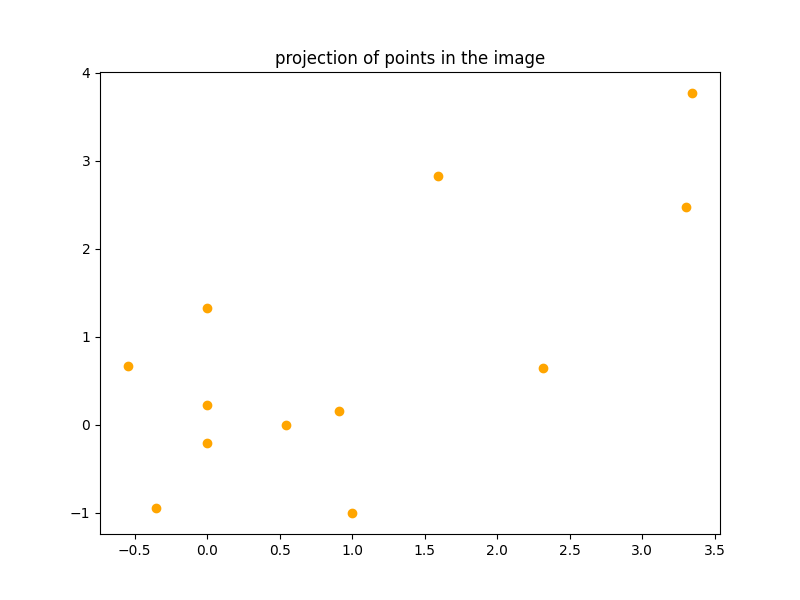

In [9]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

for i in range(n_points):
    ax.scatter(*projections.reshape(-1, 2)[i], color="orange")
    
ax.set_title("projection of points in the image")

### Perform Direct Linear Calibration

#### Create the algebraic matrix A and find P

In [10]:
# compute the algebraic matrix A
A = create_algebraic_matrix(rand_points, projections)

# compute At x A
A_ = np.matmul(A.T, A)
# compute its eigenvectors and eigenvalues
eigenvalues, eigenvectors = np.linalg.eig(A_)
# find the eigenvector with the minimum eigenvalue
# (numpy already returns sorted eigenvectors wrt their eigenvalues)
p_vector = eigenvectors[:, 11]

# reshape p back to a matrix P
P = p_vector.reshape(3, 4)

#### Compute predictions from the calibrated matrix P

In [11]:
predictions = compute_world2img_projection(rand_points, P, is_homogeneous=False)


#### plot predictions and the groundtruth

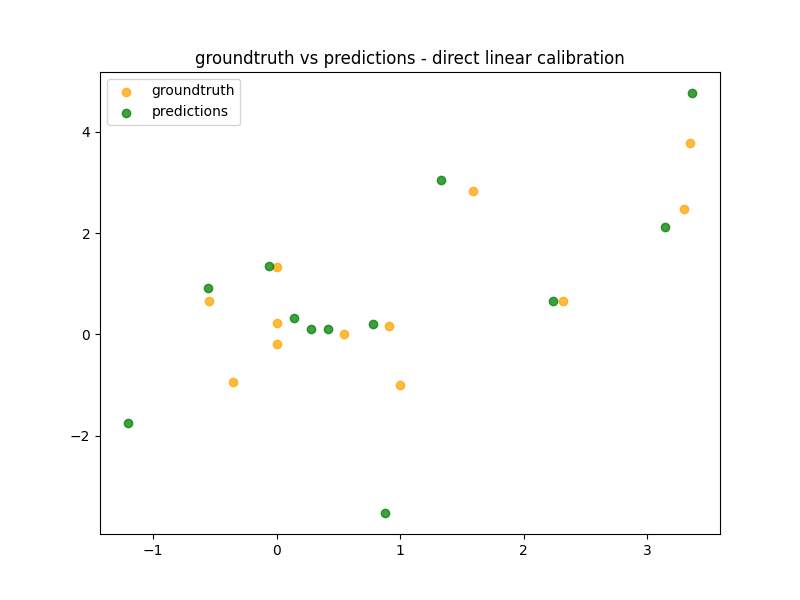

In [12]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

for i in range(n_points):
    if i == 0:
        o_label = "groundtruth"
        g_label = "predictions"
    else:
        o_label = ""
        g_label = ""
        
    ax.scatter(*projections.reshape(-1, 2)[i], color="orange", alpha=0.75, label=o_label)
    ax.scatter(*predictions.reshape(-1, 2)[i], color="green", alpha=0.75, label=g_label)
    
ax.set_title("groundtruth vs predictions - direct linear calibration")
ax.legend()

### Optimizing wrt Geometric Error

In [13]:
from scipy.optimize import minimize

In [14]:
result = minimize(geometric_error, p_vector, args=(rand_points, projections))

In [15]:
P_ = result.x.reshape(3, 4)

In [16]:
predictions_v2 = compute_world2img_projection(rand_points, P_, is_homogeneous=False)

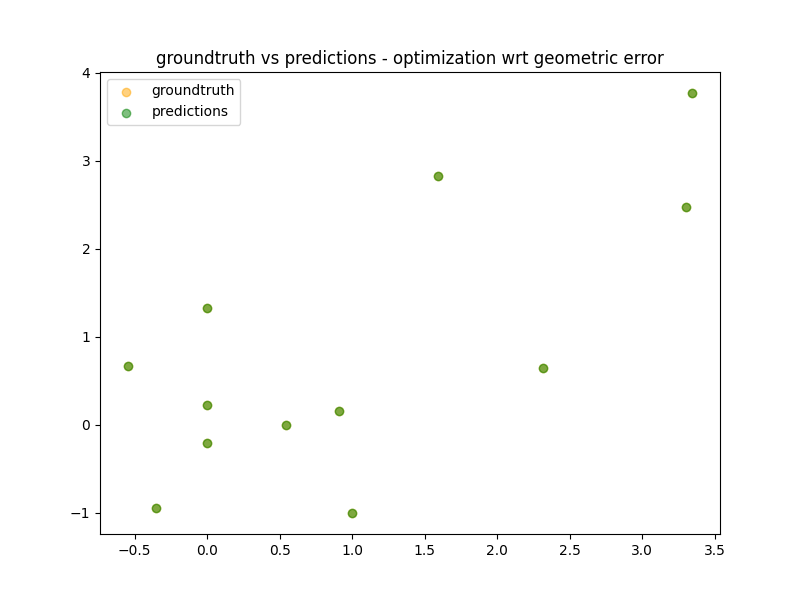

In [17]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

for i in range(n_points):
    if i == 0:
        o_label = "groundtruth"
        g_label = "predictions"
    else:
        o_label = ""
        g_label = ""
        
    ax.scatter(*projections.reshape(-1, 2)[i], color="orange", alpha=0.5, label=o_label)
    ax.scatter(*predictions_v2.reshape(-1, 2)[i], color="green", alpha=0.5, label=g_label)
    
ax.set_title("groundtruth vs predictions - optimization wrt geometric error")
ax.legend()

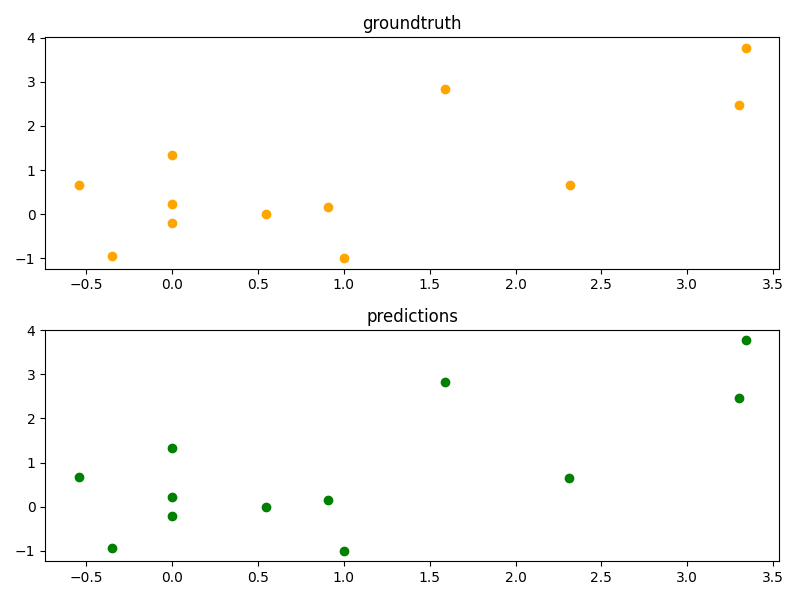

In [18]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 6))

for i in range(n_points):
        
    axes[0].scatter(*projections.reshape(-1, 2)[i], color="orange", label=o_label)
    axes[1].scatter(*predictions_v2.reshape(-1, 2)[i], color="green", label=g_label)
    
axes[0].set_title("groundtruth")
axes[1].set_title("predictions")

plt.tight_layout()

In [19]:
import scipy

In [34]:
def factorize(P):
    M = P[:,0:3]
    
    K_est,R_est = scipy.linalg.rq(M)
    
    T = np.diag(np.sign(np.diag(K_est)))
    
#    if scipy.linalg.det(T) < 0:
 #       T[1,1] *= -1
    
    K_est = np.dot(K_est,T)
    R_est = np.dot(T,R_est)
    
    C_est = np.dot(scipy.linalg.inv(-M),P[:,3])
    return(K_est,R_est,C_est)
# more info here: https://ksimek.github.io/2012/08/14/decompose/

    
K_est,R_est,C_est = factorize(P_)

print('estimated K')
print(np.round(K_est/K_est[2,2], 2))
print('true K')
print (K)
print('estimated R')
print(np.round(R_est,2))
print('true R')
print(np.round(R,2))
print('C')
print(C_est)

estimated K
[[ 2. -0. -0.]
 [ 0.  2. -0.]
 [ 0.  0.  1.]]
true K
[[2. 0. 0.]
 [0. 2. 0.]
 [0. 0. 1.]]
estimated R
[[-0.71 -0.   -0.71]
 [ 0.   -1.    0.  ]
 [ 0.71  0.   -0.71]]
true R
[[ 0.71  0.   -0.71]
 [ 0.    1.    0.  ]
 [ 0.71  0.    0.71]]
C
[ 1.36950176e-04 -8.00040015e+00 -3.49206156e-04]
